## Outliers detection

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import time
import re
from langdetect import detect

from collections import Counter

import gc

In [2]:
FILENAME = "../data/train_series.csv"
FILENAME_ECB = "../data/ecb_data.csv"
FILENAME_FED = "../data/fed_data.csv"

In [3]:
ecb = pd.read_csv(FILENAME_ECB, index_col=0)
fed = pd.read_csv(FILENAME_FED, index_col=0)
train_data = pd.read_csv(FILENAME, index_col=0)

In [5]:
train_data.head()

,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,index ecb,index fed,Index + 1
0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,"1126,1471",96,0.010597
1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,975,568,0.014492
2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,"78,806","328,695",0.016263
3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,"560,1405",118,0.013581
4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,404,261,0.005092


In [8]:
train_data.shape

(8946, 14)

In [11]:
train_data.isna().sum()

Index Name    0
Index - 9     0
Index - 8     0
Index - 7     0
Index - 6     0
Index - 5     0
Index - 4     0
Index - 3     0
Index - 2     0
Index - 1     0
Index - 0     0
index ecb     0
index fed     0
Index + 1     0
dtype: int64

### Z Scores 

In [67]:
df = train_data.copy()

cols = [f'Index - {i}' for i in range(9,0,-1)] + ['Index - 0', 'Index + 1']

means = df[cols].mean()
stds = df[cols].std()

z_scores = pd.DataFrame()
for col in cols:
    z_scores[col] = (df[col] - means[col]) / stds[col]

threshold = 3
outliers = (z_scores > threshold) | (z_scores < -threshold)

print(outliers.sum())

outlier_indices = np.unique(np.where(outliers)[0])
print(outlier_indices)


Index - 9    199
Index - 8    195
Index - 7    188
Index - 6    195
Index - 5    194
Index - 4    200
Index - 3    193
Index - 2    191
Index - 1    186
Index - 0    189
Index + 1    193
dtype: int64
[  15   18   20 ... 8933 8937 8938]


In [68]:
df.describe()

,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1
count,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000
mean,-0.000008,0.000200,0.000255,0.000339,0.000090,0.000407,0.000644,0.000988,0.000847,0.000950,0.000254
std,0.040715,0.040788,0.039987,0.040587,0.039230,0.039386,0.040104,0.039900,0.040365,0.040699,0.040765
min,-0.355095,-0.355095,-0.355095,-0.355095,-0.355095,-0.355095,-0.350588,-0.350588,-0.345301,-0.345301,-0.453881
25%,-0.011516,-0.011160,-0.011122,-0.010843,-0.010698,-0.010363,-0.010435,-0.010155,-0.010360,-0.010515,-0.011235
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008365,0.008304,0.008276,0.008358,0.008156,0.008573,0.008795,0.008732,0.008855,0.009020,0.008582
max,0.382167,0.382167,0.382167,0.496008,0.496008,0.496008,0.768245,0.768245,0.768245,0.768245,0.470305


In [78]:
df.loc[outlier_indices, 'Index - 0']

15     -0.064031
18      0.086707
20     -0.061635
21     -0.003290
30     -0.003499
          ...   
8931   -0.006391
8932    0.000000
8933    0.062966
8937   -0.018711
8938    0.000000
Name: Index - 0, Length: 1265, dtype: float64

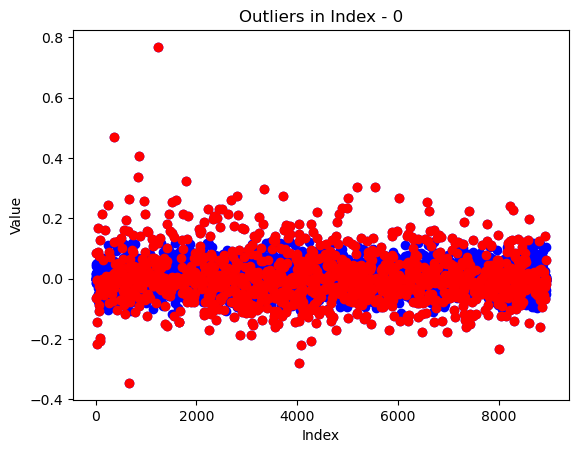

In [80]:
plt.scatter(range(len(df)), df['Index - 0'], color='blue')
plt.scatter(outlier_indices, df.loc[outlier_indices, 'Index - 0'], color='red')
plt.title('Outliers in Index - 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


### Mean Absolute Deviation

In [59]:
cols = [f'Index - {i}' for i in range(9,0,-1)] + ['Index - 0', 'Index + 1']

medians = df[cols].median()
mad = df[cols].mad()

deviations = pd.DataFrame()
for col in cols:
    deviations[col] = np.abs(df[col] - medians[col])

threshold = 4
outliers = (deviations > threshold * mad)

print(outliers.sum())

outlier_indices = np.unique(np.where(outliers)[0])
print(outlier_indices)

Index - 9    419
Index - 8    405
Index - 7    399
Index - 6    399
Index - 5    398
Index - 4    393
Index - 3    393
Index - 2    402
Index - 1    410
Index - 0    396
Index + 1    395
dtype: int64
[   0   11   13 ... 8937 8938 8942]


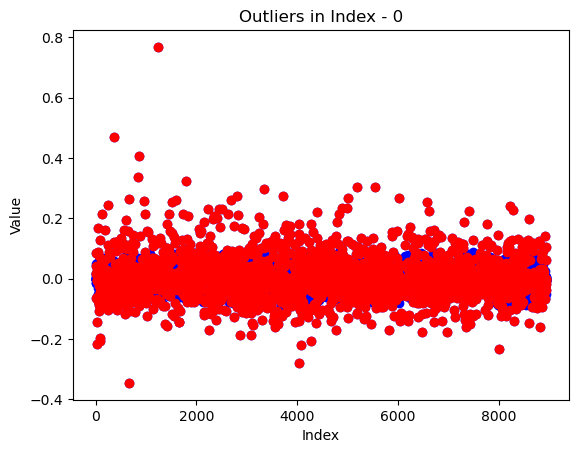

In [60]:
plt.scatter(range(len(df)), df['Index - 0'], color='blue')
plt.scatter(outlier_indices, df.loc[outlier_indices, 'Index - 0'], color='red')
plt.title('Outliers in Index - 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### Box plot

Index - 9    429
Index - 8    431
Index - 7    413
Index - 6    431
Index - 5    410
Index - 4    409
Index - 3    406
Index - 2    425
Index - 1    428
Index - 0    408
Index + 1    400
dtype: int64


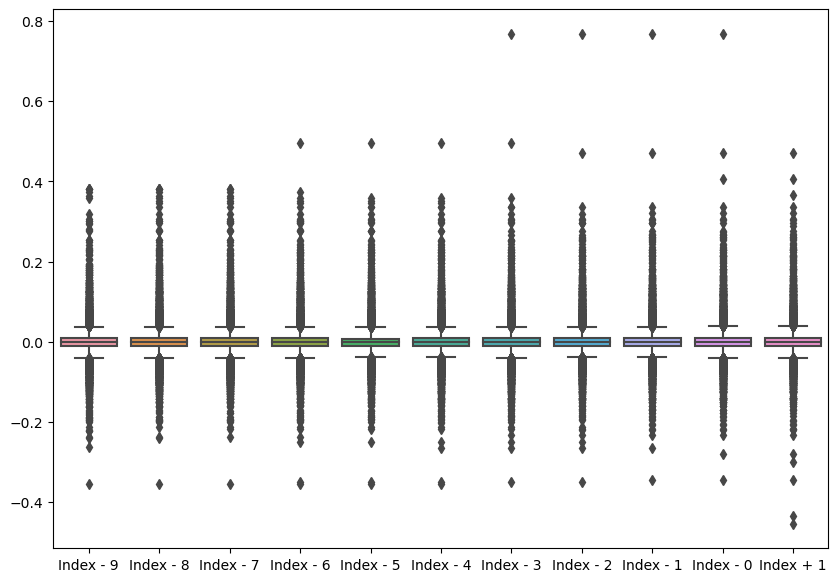

In [103]:
cols = [f'Index - {i}' for i in range(9,0,-1)] + ['Index - 0', 'Index + 1']
plt.figure(figsize=(10, 7))
sns.boxplot(data=df[cols])

whisker_length = 4

outliers = pd.DataFrame()
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - whisker_length * iqr
    upper_whisker = q3 + whisker_length * iqr
    outliers[col] = (df[col] < lower_whisker) | (df[col] > upper_whisker)

print(outliers.sum())


In [112]:
index9_upper = np.where(df['Index - 9']>0.3)
index8_upper = np.where(df['Index - 8']>0.3)
index7_upper = np.where(df['Index - 7']>0.3)
index6_upper = np.where(df['Index - 6']>0.3)
index5_upper = np.where(df['Index - 5']>0.3)
index4_upper = np.where(df['Index - 4']>0.3)
index3_upper = np.where(df['Index - 3']>0.3)
index2_upper = np.where(df['Index - 2']>0.3)
index1_upper = np.where(df['Index - 1']>0.3)
index0_upper = np.where(df['Index - 0']>0.3)
indexpos1_upper = np.where(df['Index + 1']>0.3)

print(index9_upper, index8_upper, index7_upper, index6_upper,
      index5_upper, index4_upper, index3_upper, index2_upper, index1_upper,
      indexpos1_upper, index0_upper)

(array([1384, 2077, 2685, 2762, 3257, 3996, 6263, 8000, 8025, 8880]),) (array([ 982, 2872, 3980, 4108, 4964, 5140, 5843, 6022, 6190, 6220, 7371,
       7403, 8880]),) (array([1002, 1601, 2660, 2872, 3503, 3508, 3686, 4026, 4651, 5173, 6750,
       8290]),) (array([ 788, 1194, 2289, 2685, 3508, 3716, 3759, 8000, 8009, 8419, 8725]),) (array([ 982, 1828, 2307, 4283, 4934, 5140, 7136, 8237, 8359]),) (array([ 437, 1353, 2756, 3543, 3828, 4026, 4651, 5496, 8814]),) (array([ 146,  147,  193, 2160, 3381, 5315, 6718, 8583]),) (array([ 854, 1028, 2046, 2207, 3866, 4339]),) (array([ 578,  656, 1647, 3532, 4077, 7351]),) (array([ 656, 2163, 5164, 5986, 6225, 6379, 6548]),) (array([ 359,  837,  854, 1237, 1798, 5186, 5550]),)


In [113]:
index9_lower = np.where(df['Index - 9']<-0.21)
index8_lower = np.where(df['Index - 8']<-0.21)
index7_lower = np.where(df['Index - 7']<-0.21)
index6_lower = np.where(df['Index - 6']<-0.21)
index5_lower = np.where(df['Index - 5']<-0.21)
index4_lower = np.where(df['Index - 4']<-0.21)
index3_lower = np.where(df['Index - 3']<-0.21)
index2_lower = np.where(df['Index - 2']<-0.21)
index1_lower = np.where(df['Index - 1']<-0.21)
index0_lower = np.where(df['Index - 0']<-0.21)
indexpos1_lower = np.where(df['Index + 1']<-0.21)

print(index9_lower, index8_lower, index7_lower, index6_lower, 
      index5_lower, index4_lower, index3_lower, index2_lower, 
      index1_lower, index0_lower, indexpos1_lower)


(array([1618, 3399, 3972, 4042, 4108, 4168, 4448, 5203]),) (array([2660, 4212, 8025, 8487]),) (array([1194, 2144, 7037, 7403]),) (array([1002, 3862, 5072, 6374, 7434, 8359]),) (array([ 523, 2756, 3769, 7278, 8009]),) (array([ 646, 1828, 3333, 3381, 6498, 7771]),) (array([1197, 1550, 4229, 7786, 8280, 8814]),) (array([  90,  146,  424, 1495, 2160, 5329, 5368]),) (array([ 854, 2207, 5278, 7054, 7717]),) (array([  37,  656, 4037, 4077, 8003]),) (array([ 359, 1237, 2220, 2709, 4108, 4321, 5007, 6369, 6691]),)


### LOF

In [44]:
from sklearn.neighbors import LocalOutlierFactor
cols = [f'Index - {i}' for i in range(9,0,-1)] + ['Index - 0', 'Index + 1']

data = df[cols]

lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)

lof_scores = -lof.fit_predict(data)

threshold = 2
outliers = (lof_scores > threshold)

print("Number of outliers:", outliers.sum())

outlier_indices = np.unique(np.where(outliers)[0])
print(outlier_indices)


Number of outliers: 0
[]


### SVM

In [61]:
from sklearn.svm import OneClassSVM

cols = [f'Index - {i}' for i in range(9,0,-1)] + ['Index - 0', 'Index + 1']

train_data = df[cols]

svm = OneClassSVM(gamma='auto').fit(train_data)

labels = svm.predict(df[cols])

outliers = df[labels == -1]


In [62]:
df.shape

(8946, 11)

In [63]:
outliers.index

Int64Index([   0,    8,    9,   11,   13,   15,   16,   17,   18,   19,
            ...
            8927, 8930, 8931, 8932, 8933, 8934, 8935, 8937, 8938, 8942],
           dtype='int64', length=4473)

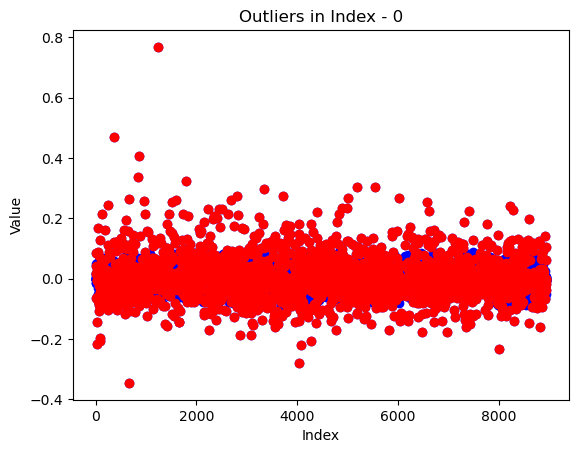

In [64]:
plt.scatter(range(len(df)), df['Index - 0'], color='blue')
plt.scatter(outlier_indices, df.loc[outlier_indices, 'Index - 0'], color='red')
plt.title('Outliers in Index - 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### Compare the models

In [114]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

def compare_outlier_methods(df):
    # Z-score method
    cols = [f'Index - {i}' for i in range(9,0,-1)] + ['Index - 0', 'Index + 1']
    means = df[cols].mean()
    stds = df[cols].std()
    z_scores = pd.DataFrame()
    for col in cols:
        z_scores[col] = (df[col] - means[col]) / stds[col]
    threshold = 3
    outliers_zscore = (z_scores > threshold) | (z_scores < -threshold)
    
    # Median absolute deviation (MAD) method
    median = df.median()
    mad = df.mad()
    threshold = 3
    outliers_mad = (df - median).abs() > threshold * mad
    
    # Box plot method
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    outliers_boxplot = (df < q1 - 1.5*iqr) | (df > q3 + 1.5*iqr)
    
    # Local Outlier Factor (LOF) method
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outliers_lof = lof.fit_predict(df) == -1
    
    # One-class SVM method
    svm = OneClassSVM(kernel='rbf', nu=0.05)
    svm.fit(df)
    outliers_svm = svm.predict(df) == -1
    
    # Combine outlier indices from all methods
    outlier_indices = np.concatenate((
        np.where(outliers_zscore.any(axis=1))[0],
        np.where(outliers_mad.any(axis=1))[0],
        np.where(outliers_boxplot.any(axis=1))[0],
        np.where(outliers_lof)[0],
        np.where(outliers_svm)[0]
    ))
    
    
    counts = np.bincount(outlier_indices)
    
    indices_to_remove = np.argsort(-counts)[:100]
      
    return indices_to_remove


In [115]:
indices_to_remove = compare_outlier_methods(df)

In [136]:
indices_to_remove

array([3951, 6200, 1194, 3996, 6220, 6221, 3980, 3964, 1162, 6276, 6290,
       1142, 2146, 1196, 6369, 1107, 2160, 6408, 8419, 2162, 3862, 6498,
       1045, 3807, 6563, 6568, 2207, 8432, 1197, 6190, 8485,  130, 4168,
       5809, 5819, 5843, 2872, 5894, 5910,  146, 4108, 8604, 5923, 5930,
       8594, 4100, 4097, 4077, 4076, 5986, 8542, 8523, 2077, 6048, 1237,
       4037, 4026,  193, 8359, 1002, 3769,  982, 3407,  656, 3087,  355,
        646,  359, 3381, 7434, 2407, 2529, 3333, 3306, 8052, 3257, 7717,
       7730,  509, 8003, 7786, 8000, 7804, 7829, 7983, 3197, 3185, 3145,
        437, 7371, 5798, 7351, 7278, 6691, 2220, 6709, 6714, 6717, 3023,
        953])

In [132]:
box_plot_upper = [index9_upper[0], index8_upper[0], index7_upper[0], index6_upper[0],
                  index5_upper[0], index4_upper[0], index3_upper[0], index2_upper[0], index1_upper[0],
                  indexpos1_upper[0], index0_upper[0]]

In [133]:
box_plot_lower = [index9_lower[0], index8_lower[0], index7_lower[0], index6_lower[0], 
                  index5_lower[0], index4_lower[0], index3_lower[0], index2_lower[0], 
                  index1_lower[0], index0_lower[0], indexpos1_lower[0]]

In [155]:
box_plot_upper.flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [164]:
from itertools import chain
s = 0
for x in list(chain(*box_plot_upper)): 
   if x in list(indices_to_remove):
        s = s + 1
print(s)
print(len(box_plot_upper))

34
11


In [165]:
from itertools import chain
s = 0
for x in list(chain(*box_plot_lower)): 
   if x in list(indices_to_remove):
        s = s + 1
print(s)
print(len(box_plot_lower))


29
11
